# 이용객 로그 데이터를 활용한 특정일의 시간대별 이용객 변화량 시각화

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 데이터 로딩후 RDD 생성
- tripdata : 2020년 3월 1일 우버 이용객 데이터
- trip_tmp : 2020년 2월 29일 23:00~ 3월 2일 12:00의 우버 이용객 데이터를 부분 추출하여
- 대용량 데이터인 관계로 17시 이전 데이터만 저장되어 있음

In [3]:
lines = sc.textFile('/rdd/trip_tmp.csv')
lines

/rdd/trip_tmp.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [4]:
lines.getNumPartitions()

2

## 필요한 부분만 추출하기
- 첫번째 line의 data 확인

In [6]:
# first() action method 사용 : rdd data의 첫번째 요소를 반환
# 우버 이용객 data의 컬럼명이 문자열로 구성되어 있음
header = lines.first()
header

',dispatching_base_num,request_datetime,driver_pay'

In [7]:
# header를 제외한 나머지 data rdd 객체만 생성 - rddData는 부분 접근이 불가
filter_lines = lines.filter(lambda row : row!=header)
filter_lines

PythonRDD[6] at RDD at PythonRDD.scala:53

In [14]:
header
filter_lines

',dispatching_base_num,request_datetime,driver_pay'

PythonRDD[6] at RDD at PythonRDD.scala:53


```python
def f(row):
    return row != header
lines.filter(f) 
```

*데이터*
```
HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,
HV0005,B02510,2020-03-01 00:28:05,2020-03-01 00:38:57,168,119,
HV0003,B02764,2020-03-01 00:03:07,2020-03-01 00:15:04,137,209,1
HV0003,B02764,2020-03-01 00:18:42,2020-03-01 00:38:42,209,80,
HV0003,B02764,2020-03-01 00:44:24,2020-03-01 00:58:44,256,226,
...
```

- 날짜/시간 data를 활용해서
    - 날짜별로 counting해서 그래프로 연결
         - data에 날짜별로 불균형(연습용이므로 data 그대로 사용)
    - 시간별로 counting해서 시계열 그래프로 연결
        - 3월 1일과 2일에 공통으로 수집된 시간이 0~12이므로
        - 0~12시까지 시간대별 이용객을 추출해서 시계열 그래프로 표현

**map()**함수로 우리가 원하는 부분만 추출 할 수 있다


추출하는 함수
```python
lambda x: x.split(",")[2].split(" ")[0]

```
아래와 같다

```python]
def f(x):
    return x.split(",")[2].split(" ")[0]
```


오리지널 데이터
```
HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,
```

x.split(",")
```
[HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,]
```


x.split(",")[2]
```
[2020-03-01 00:03:40]
```


x.split(",")[2].split(" ")
```
[2020-03-01,00:03:40]
```

x.split(",")[2].split(" ")[0]
```
2020-03-01
```

## CountByValue

In [21]:
filter_lines.map(lambda x : x.split(",")[2].split(" ")[0])

PythonRDD[14] at RDD at PythonRDD.scala:53

In [22]:
datas = filter_lines.map(lambda x : x.split(",")[2].split(" ")[0])

result = datas.countByValue()
result # 파이썬 자료구조

defaultdict(int,
            {'2020-03-01': 780219, '2020-02-29': 5603, '2020-03-02': 262753})

값이 얼마나 등장하는지 세준다 

예)
```
2020-03-01
2020-03-01
2020-03-01
2020-03-02
2020-03-02
2020-03-03
```
countByValue()
```
(2020-03-01,3)
(2020-03-02,2)
(2020-03-03,1)
```


**result는 이제 더이상 RDD가 아닌 Python 객체**

In [24]:
# 아래는 Spark코드가 아닌 일반적인 파이썬 코드
# CSV로 결과값 저장 
import pandas as pd

# dict를 csv로 저장하기 위해서는 series로 구성해서 to_csv()
pd.Series(result, name = "trips").to_csv("./data/rdd/trip_data.csv")

### 현재 data는 2020-02-29 23:00 ~ 2020-03-02 12:00까지 데이터
- 데이터 수집에서 편향이 심한 데이터이므로 비교 시각화가 무의미함
- 연습용으로 그래프를 그려봄

<Axes: >

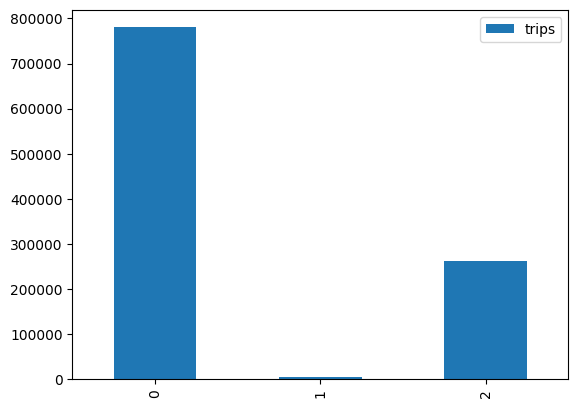

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline  

trips = pd.read_csv("./data/rdd/trip_data.csv")
trips.plot(kind="bar")

,Unnamed: 0,trips
0,2020-03-01,780219
1,2020-02-29,5603
2,2020-03-02,262753


### 시간대별 여행자 count
- data가 2020-02-29일 23시 이후부터 2020-03-02 12:00 까지 데이터 이므로
    - 0시부터 12시까지의 data만 활용해 3월1일과 3월 2일 오전 이용객에 대해 시간대별 비교 시각화를 진행

In [31]:
times = filter_lines.map(lambda x : x.split(",")[2].split(" ")[1].split(":")[0])
# times.collect()

# 시간대별 이용객 집계
res_time = times.countByValue()
# res_time

# dict를 시리즈로 변환한 후
tmp_time = pd.Series(res_time)
# tmp_time
tmp_time.index = [int(idx) for idx in tmp_time.index.values]
tmp_time.head() # 수치형 인덱스

0     67234
23    29809
16    40599
1     49807
2     36315
dtype: int64

In [35]:
# 시간대별 흐름 확인을 위해 index 기준으로 정렬
tmp_time = tmp_time.sort_index()

In [36]:
finTime = tmp_time[0:13]
finTime

0     67234
1     49807
2     36315
3     28311
4     23972
5     25142
6     37490
7     55134
8     65410
9     63140
10    63445
11    63164
12    47753
dtype: int64

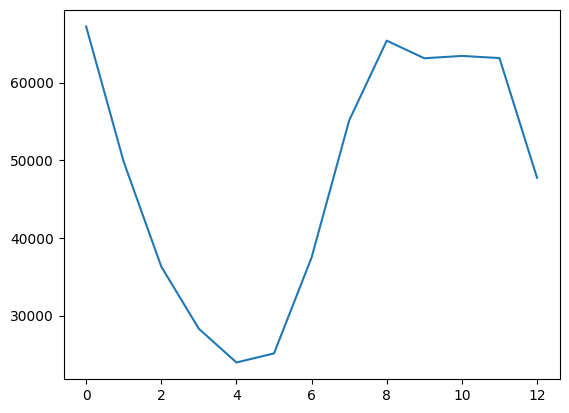

In [37]:
from matplotlib import pyplot as plt
plt.plot(finTime)